In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import time
import ray
%matplotlib ipympl

In [4]:
def compute_distance(xs,ys,xr,yr):
    return np.sqrt((xs-xr)**2+(ys-yr)**2)    

def generate_delayed_pulse(plen,pwidth,d,c,t): #la distance et la vitesse du pulese conditionne le dt qui devra être appliqué 
    '''Fonction permettant de créer un tableau contenant les divers pulses delayed des différents receivers pour une source donnée'''
    wavelet = sp.ricker(plen,pwidth)
    
    tpulse = d/c #calcule les différents temps d'arrivée du pulse au lvl des différents receivers
    tpulse = np.round(tpulse, decimals=2) #grace au round on est sûr qu'il arrive à trouver un indice pour le tpsule dans t
    
    dt = t[1]-t[0]
    
    #on sait à quel temps on doit avoir le pulse, donc à quel temps doit faire la convolution
    
    dirac = np.zeros((len(tpulse),len(t))) # nombre de receivers en ligne et durée du signal en colonnes
    trace = np.zeros((len(tpulse),len(t)))
    
    #on boucle sur l'ensemble des stations et pour chaque station on met le pulse au temps associé
    for i in range(len(tpulse)):
        #dirac[i,np.where(t==tpulse[i])] = 1 #pour une certaine raison ça ne focntionne pas tout le temps...  
        dirac[i,int((1/dt)*tpulse[i])] = 1
        trace[i,:] = np.convolve(dirac[i,:],wavelet,mode='same')
    return trace

def compute_crosscorr(trace):
    return np.correlate(trace[0,:],trace[1,:], mode='full')
    
def generate_sources(xmin,xmax,ymin,ymax,number):
    xs = np.random.randint(low=xmin,high=xmax,size=number)
    ys = np.random.randint(low=ymin,high=ymax,size=number)
    return xs,ys

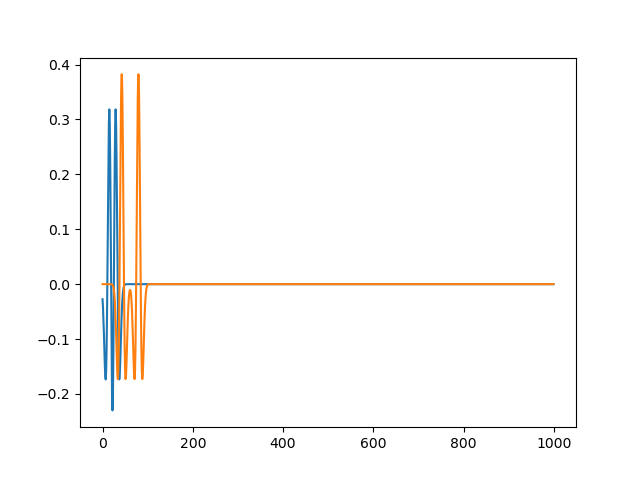

In [5]:
#visu avec ondes P et S

xs,ys = 0,0

xr = np.array([100,200])
yr = np.array([200,-600])

c1,c2 = 1500,800  #une seule famille d'onde for now

t = np.arange(0,10,0.01) 

d = compute_distance(xs,ys,xr,yr)
trace1 = generate_delayed_pulse(50,5,d,c1,t)
trace2 = generate_delayed_pulse(50,5,d,c2,t)
trace = trace1+trace2

plt.figure()
plt.plot(trace[0,:])
plt.plot(trace[1,:])
#c'est bon ça focntionne comme souhaité, il y a bien 2 pulse pour chaque trace 

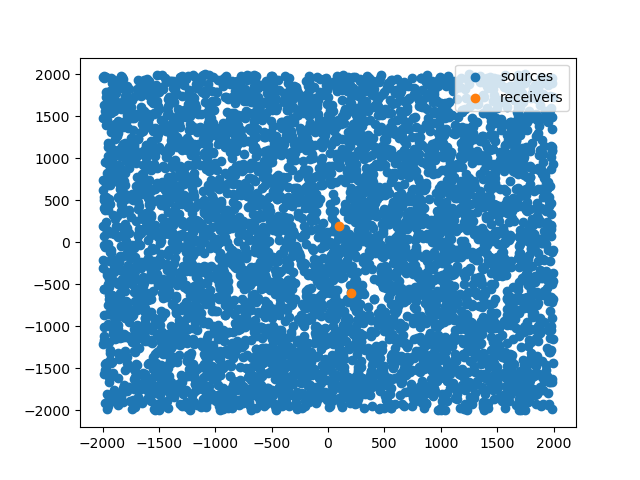

In [6]:
xs,ys = generate_sources(-2000,2000,-2000,2000,5000)
xr = np.array([100,200])
yr = np.array([200,-600])

plt.figure()
plt.scatter(xs,ys, label='sources')
plt.scatter(xr,yr,label='receivers')
plt.legend()

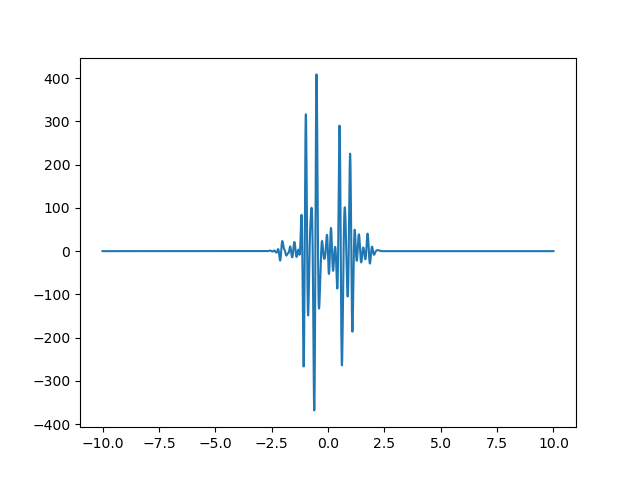

In [7]:
#on va simplement faire une boucle sur les sources et sommer dans la boucle le résultat de chacune des cross corrélations, on s'embête pas

c1,c2 = 1500,800 

t = np.arange(0,10,0.01) 

corr = np.zeros(2*len(t)-1)
lag = np.linspace(-10,10,len(corr))

for i in range (len(xs)):
    d = compute_distance(xs[i],ys[i],xr,yr)
    trace1 = generate_delayed_pulse(50,5,d,c1,t)
    trace2 = generate_delayed_pulse(50,5,d,c2,t)
    trace = trace1+trace2
    corr += compute_crosscorr(trace)
    
plt.figure()
plt.plot(lag,corr)

Text(0.5, 0, 'lag')

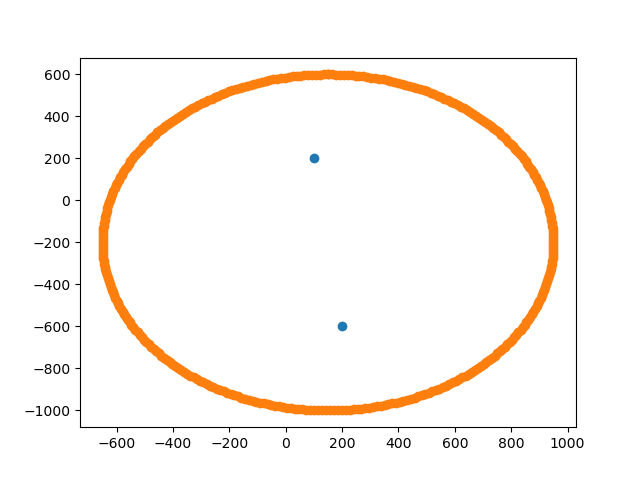

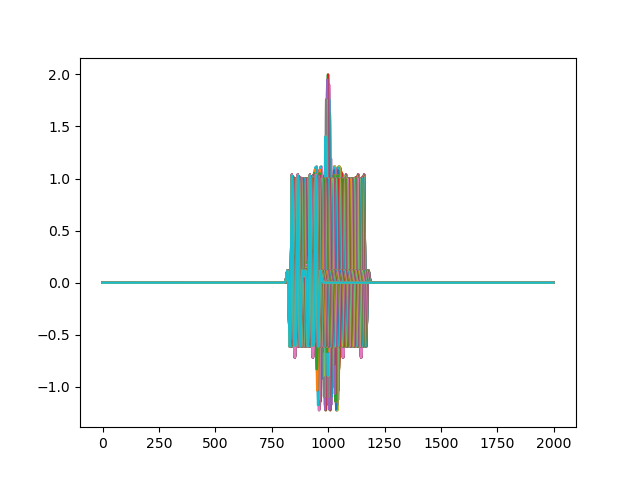

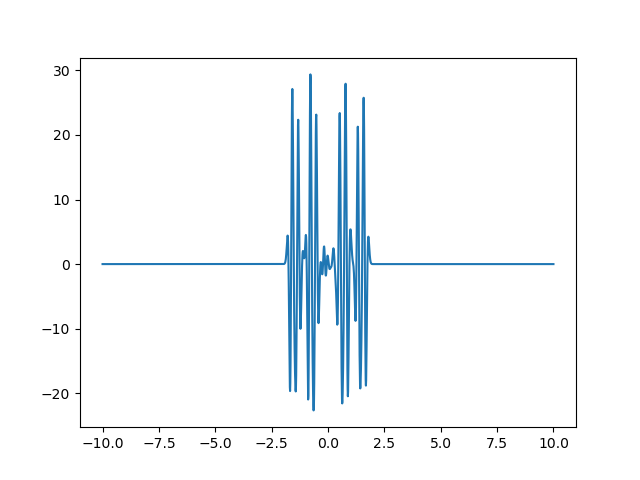

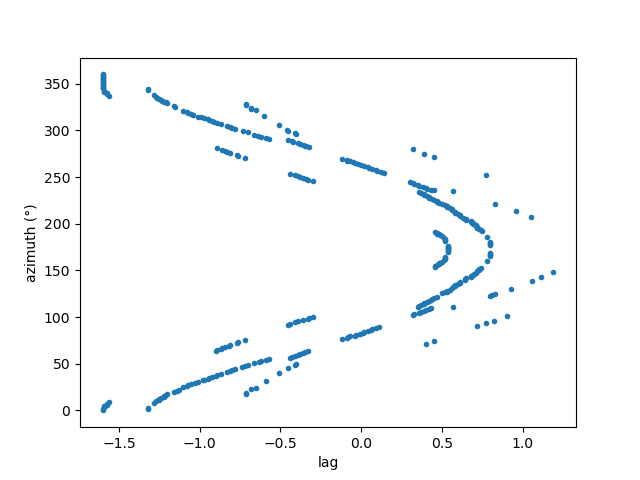

In [8]:
#on refait l'exp mais avec des sources en cercle autour de la paire

c1,c2 = 1000,600 

x0 = np.mean(xr)
y0 = np.mean(yr)   #on met les sources sur un cercle centré sur le barycentre des deux récepteurs

rayon = 800
angles = np.linspace(0,2*np.pi,360) 

xs_cercle = x0+rayon*np.sin(angles)
ys_cercle = y0+rayon*np.cos(angles)

#plots pour vérifier la position des sources par rapport aux stations
plt.figure()
plt.scatter(xr,yr)
plt.scatter(xs_cercle,ys_cercle)


t = np.arange(0,10,0.01) 

corr = np.zeros(2*len(t)-1)
lag = np.linspace(-10,10,len(corr))


lag_list = []

corrsum = np.zeros(2*len(t)-1)

plt.figure()
for i in range (len(xs_cercle)):
    d = compute_distance(xs_cercle[i],ys_cercle[i],xr,yr)
    tracep1 = generate_delayed_pulse(50,5,d,c1,t)
    tracep2 = generate_delayed_pulse(50,5,d,c2,t)
    trace = tracep1+tracep2
    corr = compute_crosscorr(trace)
    plt.plot(corr)
    corrsum += corr
    lag_list.append(lag[np.where(abs(corr)==max(abs(corr)))][0]) 
    
    
#plot   angle en focntion du lag doit voir espèce de sinusoïde    

#plot du résultat de la corrélation
plt.figure()
plt.plot(lag,corrsum) #le résultat avec sources evenly distributed est encore plus parfait qu'avec pos aléatoires

plt.figure()
plt.plot(lag_list,np.rad2deg(angles), linewidth=0, marker='.')
plt.ylabel('azimuth (°)')
plt.xlabel('lag')

#on voit qu'effectivement ça fonctionne pas avec deux ondes différentes 
#peut être on peut essayer de retrouver la forme des sinusoides du plot, et avec ces formes retrouver



175.8130235671997


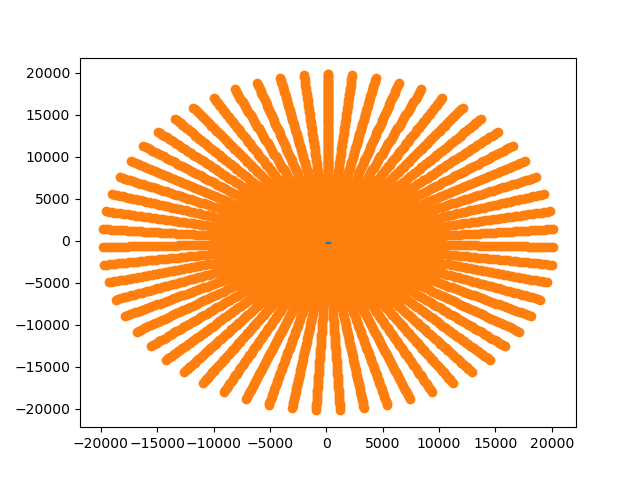

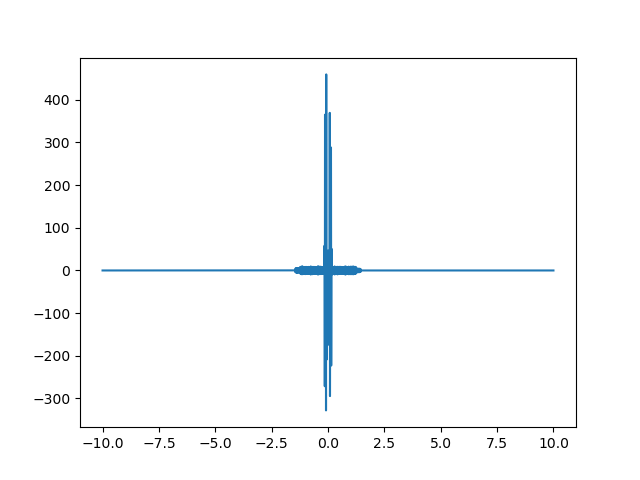

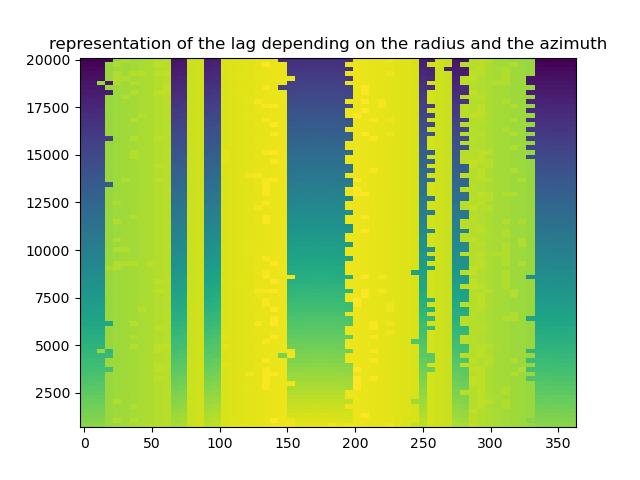

In [9]:
#maintenant on va essayer d'épaissir le cercle 

#on refait l'exp mais avec des sources en cercle autour de la paire

time1 = time.time()

c1,c2 = 1000,600 

x0 = np.mean(xr)
y0 = np.mean(yr)   #on met les sources sur un cercle centré sur le barycentre des deux récepteurs

rayon = np.linspace(800,20000,80)
angles = np.linspace(0,2*np.pi,60) 

xs_cercle = []
ys_cercle = []

for i in range(len(rayon)):
    xs_cercle += np.ndarray.tolist(x0+rayon[i]*np.sin(angles))
    ys_cercle += np.ndarray.tolist(y0+rayon[i]*np.cos(angles))

xs_cercle,ys_cercle = np.array(xs_cercle), np.array(ys_cercle) 


#plots pour vérifier la position des sources par rapport aux stations
plt.figure()
plt.scatter(xr,yr)
plt.scatter(xs_cercle,ys_cercle)


t = np.arange(0,100,0.01) 

corr = np.zeros(2*len(t)-1)
lag = np.linspace(-10,10,len(corr))


lag_list = []

corrsum = np.zeros(2*len(t)-1)

#plt.figure()
for i in range (len(xs_cercle)):
    d = compute_distance(xs_cercle[i],ys_cercle[i],xr,yr)
    tracep1 = generate_delayed_pulse(50,5,d,c1,t)
    tracep2 = generate_delayed_pulse(50,5,d,c2,t)
    trace = tracep1+tracep2
    corr = compute_crosscorr(trace)
    #plt.plot(corr)
    corrsum += corr
    lag_list.append(lag[np.where(corr==max(corr))][0]) 

    
print(time.time()-time1)
    
#plot   angle en focntion du lag doit voir espèce de sinusoïde    

#plot du résultat de la somme des corrélations
plt.figure()
plt.plot(lag,corrsum) #le résultat avec sources evenly distributed est encore plus parfait qu'avec pos aléatoires


#on plot maintenant le pcolor accosié aux difféntes dirréections avec les différents rayons!!!

#on réorganise sous forme de kernel la lag list
lag_list = np.reshape(lag_list, (len(rayon),len(angles)))

plt.figure()
plt.title('representation of the lag depending on the radius and the azimuth')
plt.pcolormesh(np.rad2deg(angles),rayon,lag_list)

#on voit qu'effectivement ça fonctionne pas avec deux ondes différentes 

on voit qu'en étendant la range à l'infini, le résultat est de mieux en mieux  (cellule suiavante le résultat en allant jusqu'à 50000 de rayon et avec une fort résolution spatiale)

19999
19999
1028.3492025891005
613.0994485398137


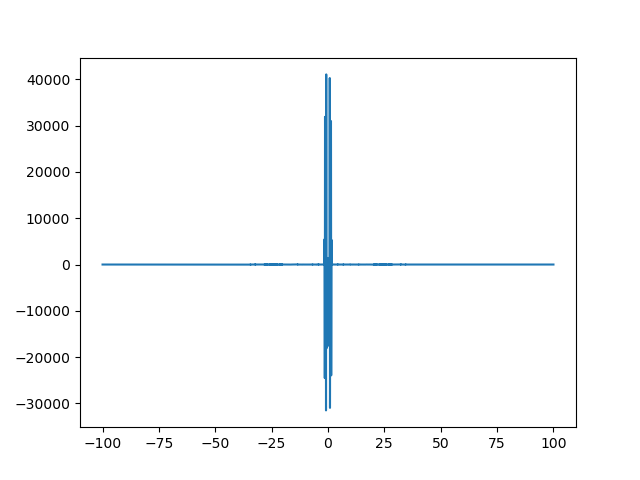

In [20]:
t = np.arange(0,100,0.01)
lag = np.arange(-99.99, 100, 0.01)
print(len(lag))

data = np.loadtxt('out_corrsum')

print(len(data))
plt.figure()
plt.plot(lag,data)

d_sta = np.sqrt((xr[0]-xr[1])**2+ (yr[0]-yr[1])**2)
v1 = d_sta/0.784
v2 = d_sta/1.315
print(v1)
print(v2)
#on a bien recover la focntion de Green !

### Parallelisation 

Testing block

33.13930320739746


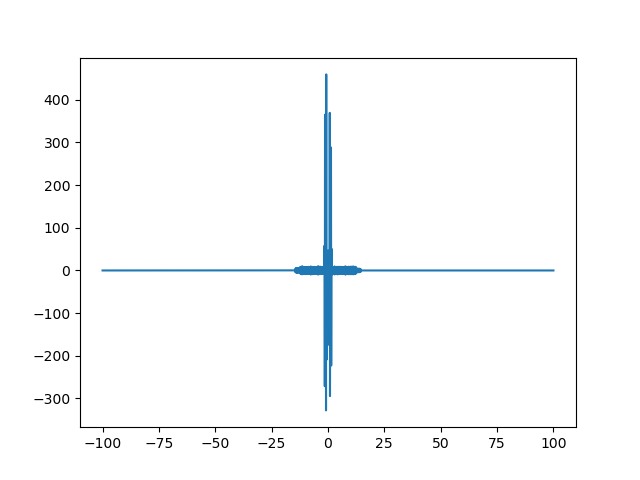

In [10]:
time1 = time.time()

x0 = np.mean(xr)
y0 = np.mean(yr)   #on met les sources sur un cercle centré sur le barycentre des deux récepteurs

t = np.arange(0,100,0.01)

lag = np.arange(-99.99,100,0.01)

rayon = np.linspace(800,20000,80)
angles = np.linspace(0,2*np.pi,60) 

@ray.remote
def compute_corr_angles(rayon):
    '''Calcule les corréaltion pour tous les angles et les somme et ce pour un rayon donné. On va ensuite devoir boucler sur les rayons pour avoir le résultat souhaité.'''
    xs_cercle = x0+rayon*np.sin(angles)
    ys_cercle = y0+rayon*np.cos(angles)
    corrsum = np.zeros(2*len(t)-1)
    for i in range(len(angles)):
        d = compute_distance(xs_cercle[i],ys_cercle[i],xr,yr)
        tracep1 = generate_delayed_pulse(50,5,d,1000,t)
        tracep2 = generate_delayed_pulse(50,5,d,600,t)
        trace = tracep1+tracep2
        corrsum += compute_crosscorr(trace)
    return corrsum


corrsum_list = ray.get([compute_corr_angles.remote(rayon[i]) for i in range(len(rayon))])

corrsum = np.sum(corrsum_list,axis=0)

print(time.time()-time1)

plt.figure()
plt.plot(lag,corrsum)

#ça marche!!! c'est nettement plus rapide qu'avant !!!!! Et le résultat est comme attendu !! 

In [ ]:
See 

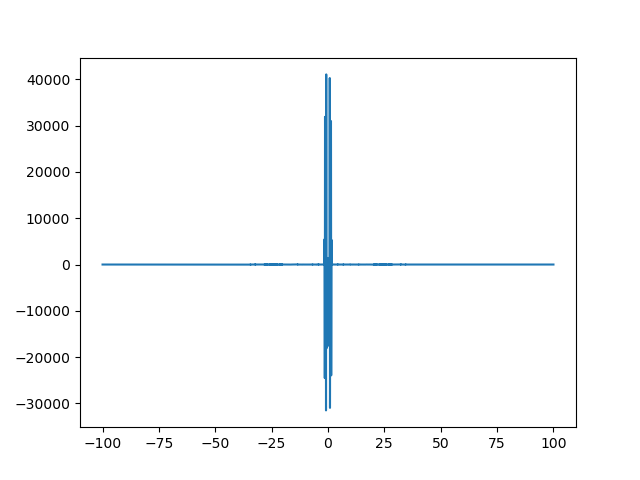

In [2]:
dat = np.loadtxt('out_corrsumv2')
t = np.arange(0,100,0.01)

lag = np.arange(-99.99,100,0.01)

plt.figure()
plt.plot(lag,dat)